# 〇、特征工程流程：
1. 树模型筛选全特征
2. PCA进行降维
3. Lasso对PCA95%解释力度之外的特征进行沙里淘金

In [2]:
# 标准库
import gc
import itertools
import os
import pickle
import time
import warnings
from functools import wraps
from itertools import combinations

# 第三方库
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import yaml
from numba import njit, prange
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBRegressor

# 全局配置
warnings.filterwarnings("ignore")

# 配置文件读取
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [2]:
def time_it(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()  # 记录开始时间
        result = func(*args, **kwargs)  # 调用被装饰的函数
        end_time = time.time()  # 记录结束时间
        execution_time = end_time - start_time  # 计算执行时间
        print(f"Function '{func.__name__}' executed in {execution_time:.4f} seconds")
        return result  # 返回函数结果
    return wrapper

# 1.数据读取

In [3]:
# 直接从配置获取存储路径，读取包含所有特征的数据
data_with_all_features = pl.read_parquet(
    config['data_paths']['output_files']['merged_data']
)

# 2.训练集划分

In [10]:
# 方便后续检验流程，这里将之后的数据改为训练集部分的10天数据（最初方便debug所用）
# 实验过程所采用的是训练集全部数据进行pca训练
data_with_all_features_ten_days =  data_with_all_features.filter((pl.col('date_id')>=70) & (pl.col('date_id')<=80))
data_with_all_features_ten_days

stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,index_wap_std,index_ret1,index_ret1_std,index_ret1_w,index_ret6,index_ret6_std,index_ret6_w,market_volume,market_spread,market_max_spread,mfd,wap_x,reference_price_minus_far_price,reference_price_times_far_price,reference_price_far_price_imb,reference_price_minus_near_price,reference_price_times_near_price,reference_price_near_price_imb,reference_price_minus_ask_price,reference_price_times_ask_price,…,far_price_group_first_ratio,near_price_group_first_ratio,bid_price_group_first_ratio,bid_size_group_first_ratio,ask_price_group_first_ratio,ask_size_group_first_ratio,wap_group_first_ratio,imbalance_size_group_expanding_mean_108,reference_price_group_expanding_mean_108,matched_size_group_expanding_mean_108,far_price_group_expanding_mean_108,near_price_group_expanding_mean_108,bid_price_group_expanding_mean_108,bid_size_group_expanding_mean_108,ask_price_group_expanding_mean_108,ask_size_group_expanding_mean_108,wap_group_expanding_mean_108,imbalance_size_seconds_in_bucket_group_mean_ratio,reference_price_seconds_in_bucket_group_mean_ratio,matched_size_seconds_in_bucket_group_mean_ratio,far_price_seconds_in_bucket_group_mean_ratio,near_price_seconds_in_bucket_group_mean_ratio,bid_price_seconds_in_bucket_group_mean_ratio,bid_size_seconds_in_bucket_group_mean_ratio,ask_price_seconds_in_bucket_group_mean_ratio,ask_size_seconds_in_bucket_group_mean_ratio,wap_seconds_in_bucket_group_mean_ratio,imbalance_size_seconds_in_bucket_group_rank,reference_price_seconds_in_bucket_group_rank,matched_size_seconds_in_bucket_group_rank,far_price_seconds_in_bucket_group_rank,near_price_seconds_in_bucket_group_rank,bid_price_seconds_in_bucket_group_rank,bid_size_seconds_in_bucket_group_rank,ask_price_seconds_in_bucket_group_rank,ask_size_seconds_in_bucket_group_rank,wap_seconds_in_bucket_group_rank
i64,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,70,0,102375.26,1,0.999846,1.2708e7,null,null,0.999628,77945.0,1.000064,13485.78,1.0,-4.220009,3850,"""70_0_0""",0.0,null,null,0.0,null,null,0.0,66871.421875,0.000946,0.007534,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000218,0.99991,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,81.533516,1.000208,2.341745,null,null,0.999918,0.378879,1.000428,2.768819,1.0,0.887755,0.647959,0.326531,null,null,0.622449,0.076531,0.852041,0.576531,0.005102
1,70,0,0.0,0,1.000868,975990.33,null,null,0.999971,167.26,1.000868,5022.3,1.0,1.399517,3850,"""70_0_1""",0.0,null,null,0.0,null,null,0.0,66871.421875,0.000946,0.007534,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.001737,…,null,null,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,inf,0.999187,30.490795,null,null,0.999575,176.56189,0.999625,7.434778,1.0,0.913265,0.137755,0.933673,null,null,0.112245,1.0,0.19898,0.831633,0.010204
2,70,0,154079.43,1,1.000001,1.1656e6,null,null,0.999603,51163.62,1.000001,175.89,1.0,-2.040267,3850,"""70_0_2""",0.0,null,null,0.0,null,null,0.0,66871.421875,0.000946,0.007534,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000002,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,54.173454,1.000053,25.53035,null,null,0.999943,0.577202,1.000491,212.289978,1.0,0.846939,0.494898,0.908163,null,null,0.642857,0.158163,0.994898,0.979592,0.015306
3,70,0,5.3680e6,-1,0.999996,1.5564e8,null,null,0.999908,22787.0,1.00004,9799.7,1.0,-2.290011,3850,"""70_0_3""",0.0,null,null,0.0,null,null,0.0,66871.421875,0.000946,0.007534,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000044,1.000036,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,1.554966,1.000058,0.191203,null,null,0.999638,1.295991,1.000452

In [5]:
# 特征工程管道
def prepare_features(df: pl.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
    """特征预处理管道"""
    # 特征选择
    exclude_cols = ['target', 'stock_id', 'date_id', 'seconds_in_bucket', 'row_id', 'time_id']
    features = df.select(
        pl.exclude(exclude_cols) & pl.exclude(pl.String)
    )
    
    # 数据转换与清洗
    X, y = features.to_numpy(), df['target'].to_numpy()
    
    # 数据质量检查（合并检查项）
    print(
        f"数据质量报告:\n"
        f"  无穷大值: {np.isinf(X).any()}\n"
        f"  缺失值: {np.isnan(X).any()}"
    )
    
    # 数据清洗管道
    X = np.where(np.isinf(X), np.nan, X)  # 统一处理特殊值
    X = SimpleImputer(strategy='mean').fit_transform(X)
    
    # 数据集拆分与标准化
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler().fit(X_train)
    
    # 返回带列名的DataFrame
    return (
        pd.DataFrame(scaler.transform(X_train), columns=features.columns),
        pd.DataFrame(scaler.transform(X_val), columns=features.columns),
        y_train,
        y_val
    )

# 执行管道
X_train, X_val, y_train, y_val = prepare_features(data_with_all_features_ten_days)

# 统一输出格式
for name, data in zip(
    ["训练集特征", "验证集特征", "训练目标", "验证目标"],
    [X_train, X_val, y_train, y_val]
):
    print(f"{name} 形状: {data.shape}")

数据中是否存在无穷大值: True
数据中是否存在 NaN 值: True
X_train shape: (94864, 429)
X_val shape: (23716, 429)
y_train shape: (94864,)
y_val shape: (23716,)


# 3.树的特征重要性选择

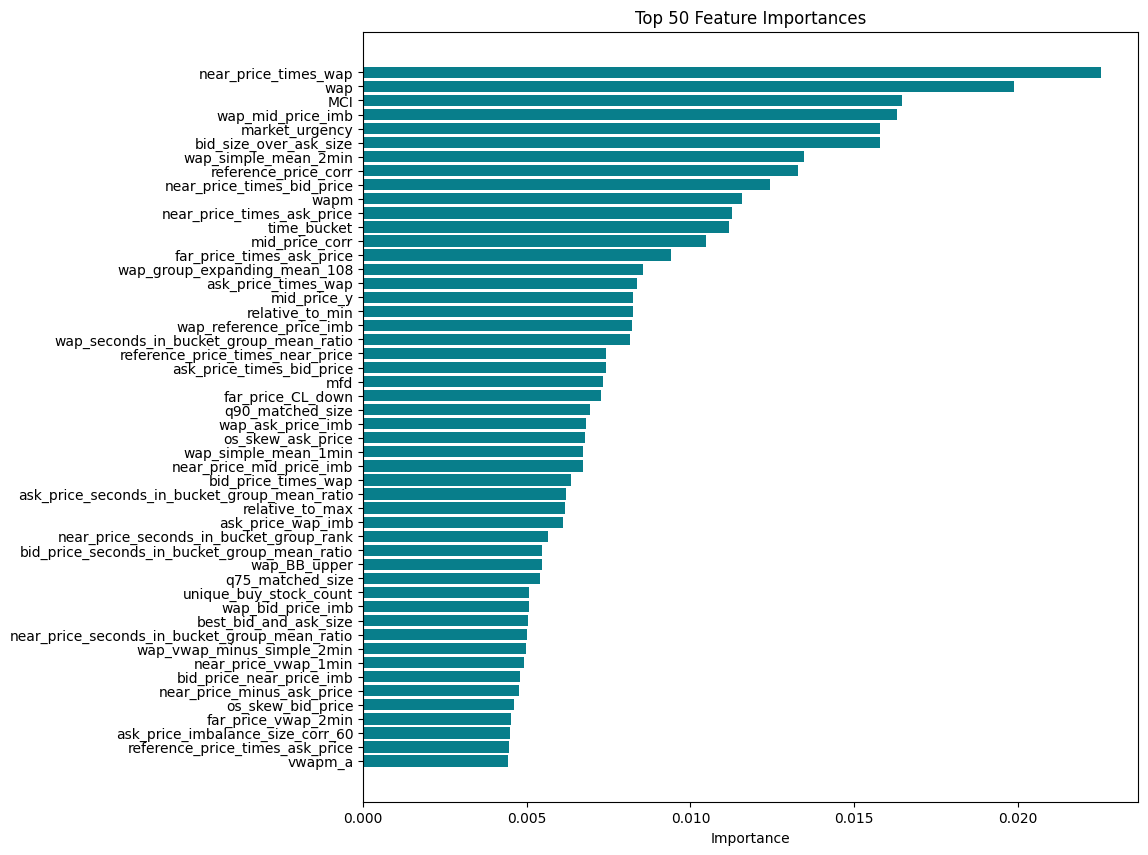

Feature: near_price_times_wap, Importance: 0.0226
Feature: wap, Importance: 0.0199
Feature: MCI, Importance: 0.0165
Feature: wap_mid_price_imb, Importance: 0.0163
Feature: market_urgency, Importance: 0.0158
Feature: bid_size_over_ask_size, Importance: 0.0158
Feature: wap_simple_mean_2min, Importance: 0.0135
Feature: reference_price_corr, Importance: 0.0133
Feature: near_price_times_bid_price, Importance: 0.0124
Feature: wapm, Importance: 0.0116
Feature: near_price_times_ask_price, Importance: 0.0113
Feature: time_bucket, Importance: 0.0112
Feature: mid_price_corr, Importance: 0.0105
Feature: far_price_times_ask_price, Importance: 0.0094
Feature: wap_group_expanding_mean_108, Importance: 0.0085
Feature: ask_price_times_wap, Importance: 0.0084
Feature: mid_price_y, Importance: 0.0083
Feature: relative_to_min, Importance: 0.0082
Feature: wap_reference_price_imb, Importance: 0.0082
Feature: wap_seconds_in_bucket_group_mean_ratio, Importance: 0.0081
Feature: reference_price_times_near_price

In [6]:
# 使用xgb模型进行第一步特征选择
model = XGBRegressor()
model.fit(X_train, y_train)

# 获取特征名称
feature_names = X.columns

# 提取特征重要性并排序
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

# 可视化前 N 个重要特征
N = 50  # 选择前 N 个特征进行可视化
plt.figure(figsize=(10, 10))
plt.barh(importances['Feature'][:N][::-1], importances['Importance'][:N][::-1], color='#087E8B')
plt.xlabel('Importance')
plt.title(f'Top {N} Feature Importances')
plt.show()

# 输出所有特征的重要性，每行一个
for feature, importance in zip(importances['Feature'], importances['Importance']):
    print(f'Feature: {feature}, Importance: {importance:.4f}')

In [7]:
threshold = 0.0001
selected_features = importances[importances['Importance'] > threshold]['Feature']
selected_features.to_csv('selected_features.txt',sep='\t')

In [9]:
# 更新训练和验证集，仅保留筛选后的特征
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

# 输出结果
print(f"原始特征数量: {X_train.shape[1]}")
print(f"筛选后特征数量: {X_train_selected.shape[1]}")

原始特征数量: 429
筛选后特征数量: 348


# 4.PCA 主成分分析

主成分分析（Principal Component Analysis，PCA）是一种统计方法，旨在通过线性变换将高维数据投影到低维空间，同时尽可能保留原始数据的主要信息。其核心思想是：

数据中心化：将原始数据的每个特征减去其均值，使数据的中心移动到原点。

计算协方差矩阵：在中心化的数据基础上，计算各特征之间的协方差矩阵，以衡量特征间的线性相关性。

特征值分解：对协方差矩阵进行特征值分解，得到特征值和对应的特征向量。特征值表示数据在对应特征向量方向上的方差大小。

选择主成分：根据特征值的大小，选择前k个特征值最大的特征向量作为主成分方向。通常，选择的主成分应能解释数据中大部分的方差。

数据投影：将原始数据投影到选定的主成分方向上，得到降维后的数据表示。

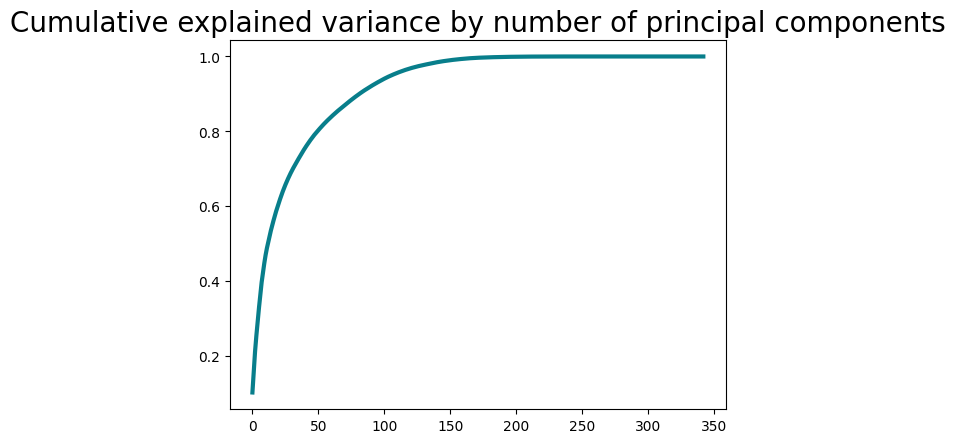

In [31]:
# 拟合PCA模型，提取主成分
pca = PCA()
pca.fit(X_train_selected)
# 计算累计解释方差
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [32]:
loadings = pd.DataFrame(
    # pca.components_每一行表示一个主成分，每列表示一个特征在该主成分上的系数。
    # 使得每个特征的系数被解释方差缩放，表示特征在各主成分上的贡献。
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train_selected.columns) + 1)],
    index=X_train_selected.columns
)
# 单元格值表示该特征在对应主成分上的载荷，即该特征在这个主成分上的贡献大小和方向。
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC334,PC335,PC336,PC337,PC338,PC339,PC340,PC341,PC342,PC343
wap_x,0.256337,-0.010011,-0.057395,-0.208291,-0.064243,-0.021789,0.025262,0.058947,0.910932,0.207003,...,0.000000e+00,-0.000000e+00,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
market_urgency,0.036392,0.025601,0.006628,-0.048757,0.099191,-0.095924,0.039964,0.041290,-0.189856,0.803404,...,1.315933e-12,-2.710921e-13,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
wapm,-0.036510,-0.025557,-0.006578,0.048818,-0.099034,0.095794,-0.039931,-0.041279,0.189894,-0.803454,...,1.315531e-12,-2.709820e-13,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
MCI,-0.013584,-0.013065,-0.006556,0.025578,-0.044024,0.044865,-0.019352,-0.016468,0.084284,-0.363346,...,2.513909e-18,7.704610e-18,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
wap,0.885937,-0.039868,-0.178943,-0.323993,0.021366,0.037038,0.032227,0.026832,-0.114656,0.018232,...,1.180637e-09,-1.496206e-09,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0


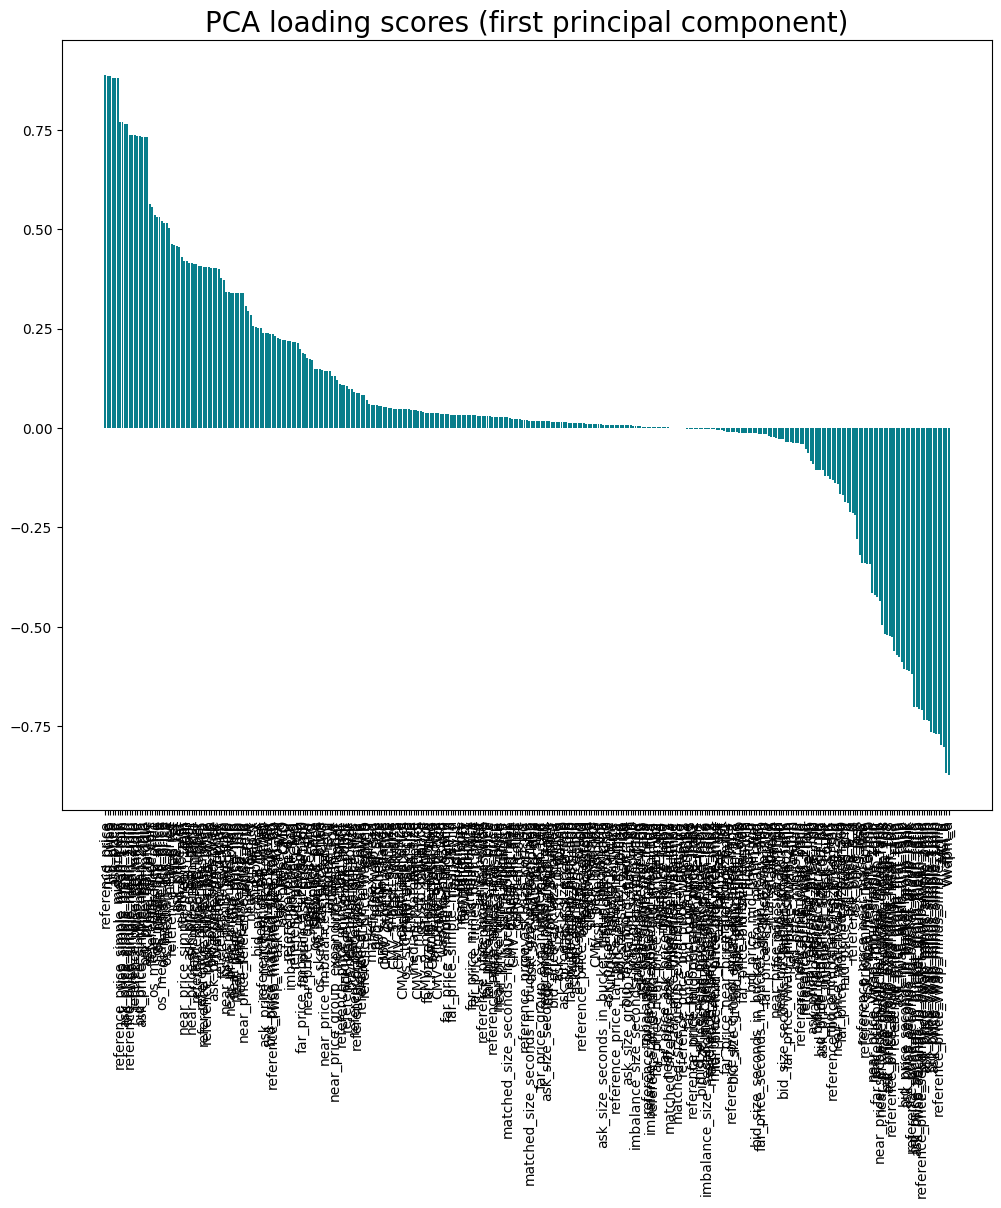

In [33]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.figure(figsize=(12, 10))
plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

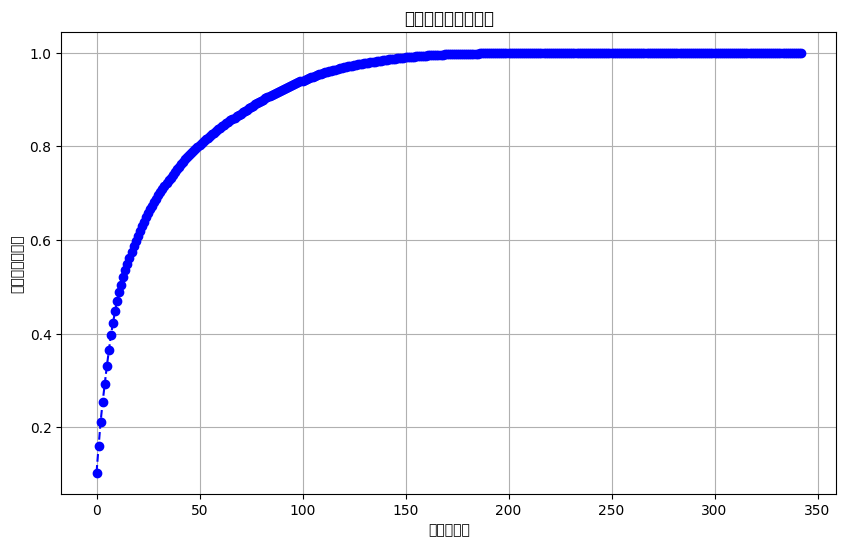

为了达到 99.0% 的累积方差贡献率，需要选择前 151 个主成分。


In [34]:
# 计算累积方差贡献率
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# 绘制累积方差贡献率曲线
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--', color='b')
plt.xlabel('主成分数量')
plt.ylabel('累积方差贡献率')
plt.title('累积方差贡献率曲线')
plt.grid(True)
plt.show()

# 设定阈值，例如 95%,阈值越低
threshold = 0.99

# 找到累积方差贡献率首次达到阈值的位置
num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

print(f"为了达到 {threshold*100}% 的累积方差贡献率，需要选择前 {num_components} 个主成分。")

# 5.保存PCA需要用到模型，方便后续上传kaggle进行处理

In [35]:
# 使用 pickle 保存模型
with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
## 使用 pickle 加载模型进行测试
# with open('scaler.pkl', 'rb') as f:
#     loaded_scaler = pickle.load(f)
# with open('pca.pkl', 'rb') as f:
#     loaded_pca = pickle.load(f)

# 6.对全数据进行PCA降维

In [ ]:
def full_data_pipeline(
    data_path: str, 
    model_paths: dict,
    feature_list_path: str
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """全量数据处理管道"""
    # 加载预处理模型
    with open(model_paths['scaler'], 'rb') as f:
        scaler = pickle.load(f)
    with open(model_paths['pca'], 'rb') as f:
        pca = pickle.load(f)

    # 数据加载与预处理
    processed_data = (
        pl.read_parquet(data_path)
        .with_columns(pl.col('p_up').fill_null(0.0))  # 统一填充缺失值
        .pipe(lambda df: df.select(
            pl.exclude(['target', 'stock_id', 'date_id', 
                       'seconds_in_bucket', 'row_id', 'time_id', 
                       'order_size_category'])
        ))
    )

    # 数据质量检查
    X_np = processed_data.to_numpy()
    print(
        f"数据质量报告:\n"
        f"  无穷大值: {np.isinf(X_np).any()}\n"
        f"  初始缺失值: {np.isnan(X_np).any()}"
    )

    # 数据清洗管道
    X_clean = (
        np.where(np.isinf(X_np), np.nan, X_np)
        .pipe(SimpleImputer(strategy='mean').fit_transform)
        .pipe(scaler.transform)
    )

    # 特征选择与PCA
    selected_features = pd.read_csv(feature_list_path, sep='\t')['Feature'].tolist()
    X_final = pd.DataFrame(X_clean, columns=processed_data.columns)[selected_features]
    X_pca = pca.transform(X_final)

    return (
        pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]),
        processed_data.select('target').to_pandas()
    )

# 执行管道
X_pca, y_all = full_data_pipeline(
    data_path='../data/data_with_all_features_5.parquet',
    model_paths={
        'scaler': 'scaler_new.pkl',
        'pca': 'pca_new.pkl'
    },
    feature_list_path='selected_features.txt'
)

# 结果保存
# X_pca.to_parquet('pca_decomposition_full.parquet')
# y_all.to_parquet('pca_label_full.parquet')

# 输出验证
print(f"特征矩阵形状: {X_pca.shape}")
print(f"目标变量形状: {y_all.shape}")

# 7.Lasso进行沙里淘金

In [ ]:
# 数据加载
# 全量数据加载（原分块数据合并后版本）
full_data = pl.read_parquet(config['data_paths']['merged_data'])
time_data = pl.read_parquet(config['data_paths']['time_data'])

# 合并时间数据
full_data = full_data.with_columns(
    time_data.select(['date_id', 'seconds_in_bucket'])
)

In [ ]:
# 特征选择准备
# 动态生成特征列名
pca_n = config['pca']['n_components']
lasso_features = [f'PC{i}' for i in range(pca_n+1, config['lasso']['max_features']+1)]

print(f"待筛选特征数量: {len(lasso_features)}")
print("示例特征:", lasso_features[:3])

In [ ]:
# 数据预处理
# 筛选训练时间段
date_range = config['lasso']['date_range']
train_data = full_data.filter(
    pl.col('date_id').is_between(date_range[0], date_range[1])
)

# 准备训练集
X_train = train_data.select(lasso_features).to_pandas()
y_train = train_data['target'].to_numpy()

In [ ]:
# 训练Lasso模型
# 初始化模型
lasso = Lasso(
    alpha=config['lasso']['alpha'],
    random_state=config['lasso']['random_state']
)

# 训练模型
lasso.fit(X_train, y_train)

In [ ]:
# 特征选择与可视化
# 获取选中特征
selected_idx = np.where(lasso.coef_ != 0)[0]
selected_features = X_train.columns[selected_idx].tolist()

# 可视化系数分布
plt.figure(figsize=(10, 4))
plt.stem(lasso.coef_, use_line_collection=True)
plt.title('Lasso Coefficients Distribution')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.show()

# 保存结果
# 保存选中的特征
final_features = [f'PC{i+1}' for i in range(config['pca']['n_components'])] + selected_features
pd.Series(final_features).to_csv(
    config['data_paths']['output_files']['final_features'],
    index=False
)

# 合并最终数据集
final_data = full_data.select(final_features + ['target'])

# 保存处理后的数据
final_data.write_parquet(config['data_paths']['output_files']['data_for_model'])
print(f"最终数据集已保存: {config['data_paths']['output_files']['data_for_model']}")